In [1]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from numpy.linalg import inv, det, norm
from math import sqrt, pi
from functools import partial
#from scipy.spatial.distance import dice

# Atlas with Histogram

In [16]:
use_atlas = 'matched-to-mni'
max_intens = 255

# Key the labels already in the files
CSF_label = 1
GM_label = 2
WM_label = 3

In [3]:
# Normalize array from 0 to max_intens
def normalize(target_array, max_intens=255):
    target_array -= target_array.min()
    normalized_array = max_intens * np.divide(target_array, target_array.max())
    return normalized_array.astype(int)

def show_slice_data(data, slice_no):
    plt.imshow(data[slice_no], cmap = "gray")
    plt.show()

# Read nii from path and normalize array from 0 to 1
def read_im(image_path):
    nii_img = nib.load(image_path)
    nii_data = nii_img.get_data()
    return nii_data, nii_img

def calc_dice(segmented_images, groundtruth_images):
    segData = segmented_images + groundtruth_images
    TP_value = np.amax(segmented_images) + np.amax(groundtruth_images)
    TP = (segData == TP_value).sum()  # found a true positive: segmentation result and groundtruth match(both are positive)
    segData_FP = 2. * segmented_images + groundtruth_images
    segData_FN = segmented_images + 2. * groundtruth_images
    FP = (segData_FP == 2 * np.amax(segmented_images)).sum() # found a false positive: segmentation result and groundtruth mismatch
    FN = (segData_FN == 2 * np.amax(groundtruth_images)).sum() # found a false negative: segmentation result and groundtruth mismatch
    return 2*TP/(2*TP+FP+FN)  # according to the definition of DICE similarity score

def dice_similarity(segmented_img, groundtruth_img):
    """
    Extract binary label images for regions.
        Inputs: segmented_img (nibabel): segmented labels nii file
                groundtruth_img (nibabel): groundtruth labels nii file
        Returns: DICE_index (float): Dice similarity score between the two images (nii files)        
    """
    
    segmented_data = segmented_img.get_data().copy()
    groundtruth_data = groundtruth_img.get_data().copy()
    seg_CSF = (segmented_data == CSF_label) * 1
    gt_CSF = (groundtruth_data == CSF_label) * 1
    seg_GM = (segmented_data == GM_label) * 1
    gt_GM = (groundtruth_data == GM_label) * 1
    seg_WM = (segmented_data == WM_label) * 1
    gt_WM = (groundtruth_data == WM_label) * 1
    
    dice_CSF = calc_dice(seg_CSF, gt_CSF)
    dice_GM = calc_dice(seg_GM, gt_GM)
    dice_WM = calc_dice(seg_WM, gt_WM)
    
    
    return dice_CSF, dice_GM, dice_WM

In [6]:
# Path to test image
test_im_path = "./registered-data/Par0009-matched-to-mni/Validation_Set/templates/"
gt_path = "./registered-data/Par0009-matched-to-mni/Validation_Set/labels/"
train_labels_path = "./registered-data/Par0009-matched-to-mni/Training_Set/labels/"
train_im_path = "./registered-data/Par0009-matched-to-mni/Training_Set/templates/"

if use_atlas == 'matched-to-mni':
    # Path to atlas image folder
    atlas_path = "./atlases/Par0009-matched-to-mni/"
    result_path = "./segmentation-results/Par0009-matched-to-mni/hist-segmentation/"
    out_dice_path = './dice-results/Par0009-matched-to-mni_hist_dice.csv'
    os.mkdir(result_path)
# elif use_atlas == 'mni':
#     # Path to test image folder
#     template_path = "./test-set/registration-results/mni_templates/"
#     atlas_path = "./test-set/registration-results/mni_atlases/"
#     result_path = "./test-set/segmentation-results/mni-atlas-hist-segmentation/"
#     out_dice_path = './dice-results/mni_atlas_hist_dice.csv'
else:
    raise ValueError("our_atlas values should be either 'no-matching' or 'our'")
    
def get_hist_probs(img, hist):
    """Returns probability values for an image based on a given histogram.
    
    Parameters:
        img (np.ndarray): input image.
        hist (np.ndarray): histogram.
    
    Returns:
        out_prob (np.ndarray): propability image.
    """
    out_prob = np.zeros_like(img, dtype='float')
    # we assume that intensity values and indices of bins correspond
    for intens_val in np.nditer(np.nonzero(hist)):
        out_prob[img == intens_val] = hist[intens_val]
    
    return out_prob

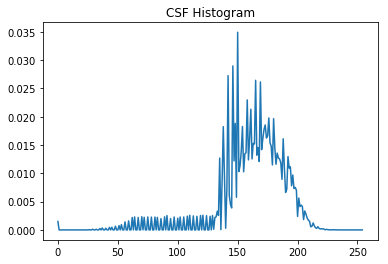

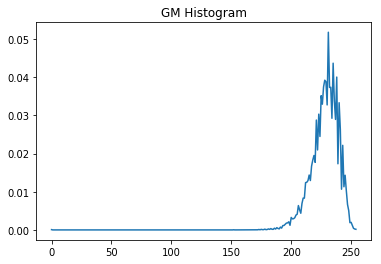

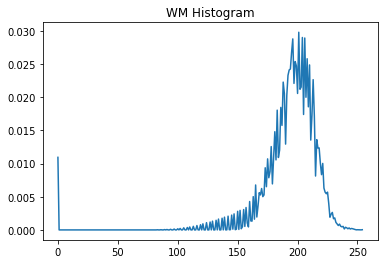

In [7]:
im_names = [f for f in listdir(train_im_path) if isdir(join(train_im_path, f))]

# Initialize arrays to hold intensity values 
# CSF_intensities, WM_intensities, GM_intensities
for i, f in enumerate(im_names):
    # Load all data for histogram
    test_data, test_img = read_im(join(train_im_path,f,'result.1.nii.gz'))
    test_data = normalize(test_data, max_intens)
    labels_data, labels_img = read_im(join(train_labels_path,f,'result.nii.gz'))

    if i == 0:
        # Initialize arrays to hold intensity values 
        CSF_intensities = test_data[labels_data == CSF_label]
        WM_intensities = test_data[labels_data == WM_label]
        GM_intensities = test_data[labels_data == GM_label]
    else:    
        CSF_intensities = np.append(CSF_intensities, test_data[labels_data == CSF_label])
        WM_intensities = np.append(WM_intensities, test_data[labels_data == WM_label])
        GM_intensities = np.append(GM_intensities, test_data[labels_data == GM_label])

# get histograms
bins = tuple(range(0, max_intens+1))
CSF_hist, _ = np.histogram(CSF_intensities, bins, density=True)
GM_hist, _ = np.histogram(GM_intensities, bins, density=True)
WM_hist, _ = np.histogram(WM_intensities, bins, density=True)
bins = bins[:-1]

# plot histograms
plt.plot(bins, CSF_hist)
plt.title("CSF Histogram")
plt.show()

plt.plot(bins, GM_hist)
plt.title("GM Histogram")
plt.show()

plt.plot(bins, WM_hist)
plt.title("WM Histogram")
plt.show()

In [8]:
onlydirs = [f for f in listdir(test_im_path) if isdir(join(test_im_path, f))]

all_dice = np.zeros((len(onlydirs),3))

GM_atlas, _ = read_im(atlas_path+'GM_probs.nii.gz')
WM_atlas, _ = read_im(atlas_path+'WM_probs.nii.gz')
CSF_atlas, _ = read_im(atlas_path+'CSF_probs.nii.gz')

for i, f in enumerate(onlydirs):
    test_data, template_img = read_im(join(test_im_path,f,'result.1.nii.gz'))
    test_data = normalize(test_data, max_intens)

    # Incorporate historgram from above
    # compute probabilities based on intensity histograms
    GM_hist_prob = get_hist_probs(test_data, GM_hist)
    WM_hist_prob = get_hist_probs(test_data, WM_hist)
    CSF_hist_prob = get_hist_probs(test_data, CSF_hist)

    # combine those probabilities
    GM_hist_prob *= GM_atlas
    WM_hist_prob *= WM_atlas
    CSF_hist_prob *= CSF_atlas

    # Assign GM, WM, CSF to voxel with highest probability
    GM = GM_label * np.nan_to_num((GM_hist_prob > CSF_hist_prob) * (GM_hist_prob > WM_hist_prob))
    WM = WM_label * np.nan_to_num((WM_hist_prob > CSF_hist_prob) * (WM_hist_prob > GM_hist_prob))
    CSF = CSF_label * np.nan_to_num((CSF_hist_prob > WM_hist_prob) * (CSF_hist_prob > GM_hist_prob))
    seg_im = GM + WM + CSF
    segmented_img = nib.Nifti1Image(seg_im, template_img.affine, template_img.header)

    # Calculate DICE
    path_gt = join(gt_path,f,"result.nii.gz")
    _, groundtruth_img = read_im(path_gt)
    all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segmented_img, groundtruth_img)

    # Make directory to save result seg
    new_dir = join(result_path,f)
    os.mkdir(new_dir)
    nib.save(segmented_img, join(new_dir,'atlas_hist_seg.nii.gz'))

print(all_dice)
with open(out_dice_path, 'w+') as out_f:
    out_f.write('img,csf,gm,wm,\n')
    for index, row in enumerate(all_dice): 
        out_f.write(onlydirs[index] + ',' + ','.join(str(j) for j in row) + ',\n')

[[0.65862816 0.81301248 0.85732961]
 [0.84133245 0.91928221 0.81975524]
 [0.81138211 0.89244209 0.8659655 ]
 [0.84700222 0.91156372 0.85727721]
 [0.84017786 0.9151384  0.81592666]]


# EM + Atlas Segmentation

In [9]:
def integrate_atlas_nii(original_im, y_pred, features_nonzero, features_nonzero_row_indicies, weights, csf_atlas, 
                           gm_atlas, wm_atlas):
    """
    Transforms segmenation result to nii file, puts correct labels in place.
    The segmentation labels should be: 1) CSF (darkest) 2) GM (middle) 3) WM (light)
    
    Inputs: 
    original_im (nibabel): original image nii file
    y_pred (np array): labels for all non-zero points
    features_nonzero (np array): feature vector of only non-zero intensities
    features_nonzero_row_indicies (np array): indicies of non-zero points,
                                              same length as y_pred

    Returns:
    segment_nii (nibabel): segmented labels nii file        
    """
    
    # Create image with all 3 classes and random labels
    y_pred = y_pred + 1
    original_img_shape = original_im.get_data().shape
    original_img_len = original_img_shape[0] * original_img_shape[1] * original_img_shape[2]
    
    segment_im = np.zeros(original_img_len)
    segment_im[features_nonzero_row_indicies] = y_pred
    segment_im = np.reshape(segment_im, original_im.shape)
    
    temp_class1_im = np.zeros_like(segment_im)
    temp_class2_im = np.zeros_like(segment_im)
    temp_class3_im = np.zeros_like(segment_im)
    
    #Assign class1 to 1
    temp_class1_im[segment_im == 1] = 1
    #Assign class2 to 2
    temp_class2_im[segment_im == 2] = 1
    #Assign class3 to 1
    temp_class3_im[segment_im == 3] = 1
    
    # Compute DICE between each class to determine which class it belongs to
    dice1 = [calc_dice(temp_class1_im, csf_atlas), calc_dice(temp_class2_im, csf_atlas), 
                                  calc_dice(temp_class3_im, csf_atlas)]
    dice2 = [calc_dice(temp_class1_im, wm_atlas), calc_dice(temp_class2_im, wm_atlas), 
                                  calc_dice(temp_class3_im, wm_atlas)]
    dice3 = [calc_dice(temp_class1_im, gm_atlas), calc_dice(temp_class2_im, gm_atlas), 
                                  calc_dice(temp_class3_im, gm_atlas)]
    csf_to_change = np.argmax(dice1) + 1
    wm_to_change = np.argmax(dice2) + 1
    gm_to_change = np.argmax(dice3) + 1
    
    
    #New y_pred
    y_pred_corrected_labels = np.zeros_like(y_pred)
    #Assign CSF to its correct label
    y_pred_corrected_labels[y_pred == csf_to_change] = CSF_label
    #Assign GM to its correct label
    y_pred_corrected_labels[y_pred == gm_to_change] = GM_label
    #Assign WM to its correct label
    y_pred_corrected_labels[y_pred == wm_to_change] = WM_label
    
    # Get weights back into original shape
    weight_csf_im = np.zeros(original_img_len)
    weight_gm_im = np.zeros(original_img_len)
    weight_wm_im = np.zeros(original_img_len)
    
    weight_csf_im[features_nonzero_row_indicies] = weights[:,csf_to_change-1]
    weight_gm_im[features_nonzero_row_indicies] = weights[:,gm_to_change-1]
    weight_wm_im[features_nonzero_row_indicies] = weights[:,wm_to_change-1]
    weight_csf_im = np.reshape(weight_csf_im, original_im.shape)
    weight_gm_im = np.reshape(weight_gm_im, original_im.shape)
    weight_wm_im = np.reshape(weight_wm_im, original_im.shape)
    
    # Multiply weights by each atlas
    csf_probs = weight_csf_im * csf_atlas
    gm_probs = weight_gm_im * gm_atlas
    wm_probs = weight_wm_im * wm_atlas
    
    # Assign GM, WM, CSF to voxel with highest probability
    GM = GM_label * np.nan_to_num((gm_probs > csf_probs) * (gm_probs > wm_probs))
    WM = WM_label * np.nan_to_num((wm_probs > csf_probs) * (wm_probs > gm_probs))
    CSF = CSF_label * np.nan_to_num((csf_probs > wm_probs) * (csf_probs > gm_probs))
    seg_im = GM + WM + CSF
    
    segment_im = np.zeros(original_img_len)
    segment_im = np.reshape(seg_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)

    return segment_nii

def gaussian_mixture(features, mean, cov):
    """
    Return Gaussian mixture function for a class.
    
    Inputs:
        features (numpy.ndarray): n by d dimentional array of features of points from feature space, where d is 
                                  is the dimentionality of feature space, n - number of points in the data.
        mean (numpy.ndarray): d-dimentional mean value.
        con (numpy.ndarray): d by d dimentional covariance matrix.
    
    Returns:
        (numpy.ndarray): Gaussian mixture for every point in feature space.
    """
    return np.exp(-0.5*(features - mean) * (1/cov) * np.transpose(features - mean)) / (2 * pi * sqrt(cov))


def membership_weight(p0, p1, p2, a0, a1, a2):
    """
    Return membership weights for three classes.
    
    Inputs:
        p0 (numpy.ndarray): mixture component for the 0th class, which is a probability distribution.
        p1 (numpy.ndarray): mixture component for the 1st class, which is a probability distribution.
        p2 (numpy.ndarray): mixture component for the 2nd class, which is a probability distribution.
        a0 (float): the probability of the 0th class.
        a1 (float): the probability for the 1st class.
        a2 (float): the probability for the 2nd class.
        
    Returns:
        (numpy.ndarray): membership weights for each point from the feature space, 
    """
    denominator = (p0 * a0) + (p1 * a1) + (p2 * a2)
    w0 = (p0 * a0) / denominator
    w1 = (p1 * a1) / denominator
    w2 = (p2 * a2) / denominator
    
    return np.stack((w0, w1, w2), axis=1)


def get_log_likelihood(class_dist, gauss_density):
    """
    Return loglikelihood.
    
    Parameters:
        class_dist: iterable with class distributions.
        gauss_density: iterable with Gaussian densities for each class.
    
    Returns:
        float: log likelihood value. 
    """
    for index, alpha in enumerate(class_dist):
        if index == 0:
            total_sum = alpha * gauss_density[index]
        else:
            total_sum += alpha * gauss_density[index]
    
    return np.sum(np.log(total_sum))


def save_dice(out_dice_path, img_names, dice_values):
    """
    Save DICE values into a csv file.
    Tissue type should be in this order: csf,gm,wm.
    
    Parameters:
        out_dice_path (str): output file path.
        img_names (list[str]): list of volumes used for dice calculation.
        dice_values (numpy.ndarray): array with dice coefficeints for each tissue type.
    
    Returns: None.
    """
    with open(out_dice_path, 'w+') as out_f:
        out_f.write('img,csf,gm,wm,\n')
        for index, row in enumerate(dice_values): 
            out_f.write(img_names[index] + ',' + ','.join(str(j) for j in row) + ',\n')

********************************************************************
Img IBSR_17
Step 0
Distribution change 0.014989
0.008458014311524006 0.41379567654707905 0.5777463091422362
********************************************************************
Img IBSR_17
Step 1
Distribution change 0.007112
0.008009577025486091 0.4993585829162545 0.49263184005938615
Loop stopped


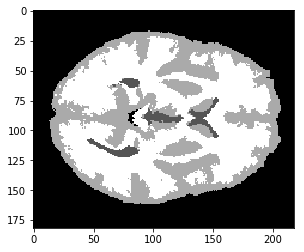

********************************************************************
Img IBSR_11
Step 0
Distribution change 0.032882
0.010225922949929394 0.48215422153696746 0.5076198555138937
********************************************************************
Img IBSR_11
Step 1
Distribution change 0.012597
0.012316495231304021 0.6091912117738811 0.3784922929972411
********************************************************************
Img IBSR_11
Step 2
Distribution change 0.005669
0.017348920250332824 0.6797624190578445 0.3028886606969747
Loop stopped


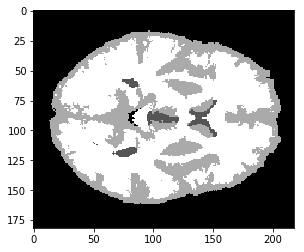

********************************************************************
Img IBSR_13
Step 0
Distribution change 0.025164
0.012990671573958975 0.4508105174096013 0.5361988110165993
********************************************************************
Img IBSR_13
Step 1
Distribution change 0.016687
0.018117786250211074 0.57984775840388 0.4020344553452858
********************************************************************
Img IBSR_13
Step 2
Distribution change 0.012604
0.023915549040622503 0.6874352182150935 0.2886492327426863
********************************************************************
Img IBSR_13
Step 3
Distribution change 0.008537
0.02913169106122745 0.765335424883776 0.2055328840543291
Loop stopped


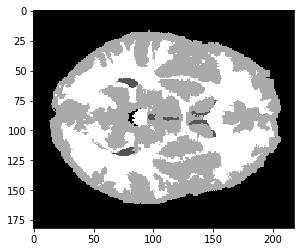

********************************************************************
Img IBSR_14
Step 0
Distribution change 0.019618
0.013528506926992884 0.437928155518379 0.5485433375569172
********************************************************************
Img IBSR_14
Step 1
Distribution change 0.016010
0.02060147847124625 0.552813486703044 0.4265850348288477
********************************************************************
Img IBSR_14
Step 2
Distribution change 0.013490
0.030180846029785786 0.6581069705872588 0.3117121833805715
********************************************************************
Img IBSR_14
Step 3
Distribution change 0.009352
0.0402918788108887 0.7371590888638764 0.22254903232571974
Loop stopped


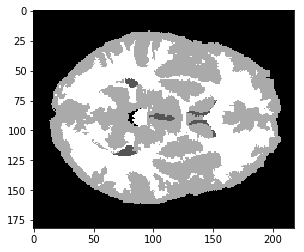

********************************************************************
Img IBSR_12
Step 0
Distribution change 0.026674
0.010010340699383847 0.47921326605820114 0.5107763932415263
********************************************************************
Img IBSR_12
Step 1
Distribution change 0.013609
0.011624557085515519 0.6025409914171168 0.3858344514930706
********************************************************************
Img IBSR_12
Step 2
Distribution change 0.007838
0.015091713980219433 0.6852456578948369 0.2996626281280688
Loop stopped


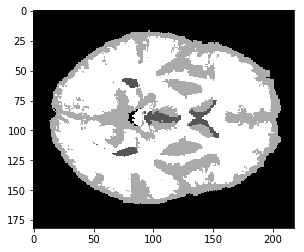

In [23]:
MAX_STEPS = 30
min_change = 0.01

# Path to test image
test_img_path = "./registered-data/Par0009-matched-to-mni/Validation_Set/templates/"
gt_path = "./registered-data/Par0009-matched-to-mni/Validation_Set/labels/"
train_labels_path = "./registered-data/Par0009-matched-to-mni/Training_Set/labels/"
train_im_path = "./registered-data/Par0009-matched-to-mni/Training_Set/templates/"

if use_atlas == 'matched-to-mni':
    # Path to atlas image folder
    atlas_path = "./atlases/Par0009-matched-to-mni/"
    result_path = "./segmentation-results/Par0009-matched-to-mni/em-segmentation/"
    out_dice_path = './dice-results/Par0009-matched-to-mni_em_dice.csv'
    #os.mkdir(result_path)
else:
    raise ValueError("our_atlas values should be either mni' or 'our'")

onlydirs = [f for f in listdir(test_im_path) if isdir(join(test_im_path, f))]

all_dice = np.zeros((len(onlydirs),3))

GM_atlas, _ = read_im(atlas_path+'GM_probs.nii.gz')
WM_atlas, _ = read_im(atlas_path+'WM_probs.nii.gz')
CSF_atlas, _ = read_im(atlas_path+'CSF_probs.nii.gz')
GM_atlas_flat = GM_atlas.flatten()
WM_atlas_flat = WM_atlas.flatten()
CSF_atlas_flat = CSF_atlas.flatten()
mask = GM_atlas + WM_atlas + CSF_atlas
mask_data = mask.copy().flatten()
mask_data = np.transpose(mask_data)

for i, f in enumerate(onlydirs):
    # Load all data for EM algorithm
    test_data, template_img = read_im(join(test_im_path,f,'result.1.nii.gz'))
    test_data = normalize(test_data, max_intens)

    _, groundtruth_img = read_im(join(gt_path,f,"result.nii.gz"))

    # Pre-process feature vector to remove background points from algorithm
    # and save those indicies to add back
    features = test_data.copy().flatten()
    features = np.transpose(features)   

    features_nonzero_row_indicies = np.nonzero(mask_data)
    features_nonzero = features[features_nonzero_row_indicies]

    # row index shifted by +1 will correspond to tissue labels from ground-truth
    features_nonzero_pred = np.array((CSF_atlas_flat[features_nonzero_row_indicies],
                                      WM_atlas_flat[features_nonzero_row_indicies],
                                      GM_atlas_flat[features_nonzero_row_indicies]))
    y_pred = np.argmax(features_nonzero_pred, axis=0)

    # intialize EM algorithm
    class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0]]
    class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0]]
    class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0]]

    # Compute mean and variance of each class
    mean0 = np.mean(class0, axis = 0)
    mean1 = np.mean(class1, axis = 0)
    mean2 = np.mean(class2, axis = 0)
    cov0 = np.cov(class0, rowvar = False)
    cov1 = np.cov(class1, rowvar = False)
    cov2 = np.cov(class2, rowvar = False)

    # Class distribution
    a0 = class0.shape[0] / features_nonzero.shape[0]
    a1 = class1.shape[0] / features_nonzero.shape[0]
    a2 = class2.shape[0] / features_nonzero.shape[0]

    # Compute Gaussian mixture model for each point
    p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
    p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
    p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)

    # # Compute membership weight for each point
    weights = membership_weight(p0, p1, p2, a0, a1, a2)
    # get initial log-likelihood
    log_likelihood = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

    n_steps = 0

    while True:
        # Maximization step: Use that classification to reestimate the parameters
        # Class distribution
        counts = np.sum(weights, axis=0)

        a0 = counts[0] / len(features_nonzero)
        a1 = counts[1] / len(features_nonzero)
        a2 = counts[2] / len(features_nonzero)

        # Calculate mean and covariance for new classes
        mean0 = (1/counts[0]) * (weights[:, 0] @ features_nonzero)
        mean1 = (1/counts[1]) * (weights[:, 1] @ features_nonzero)
        mean2 = (1/counts[2]) * (weights[:, 2] @ features_nonzero)
        cov0 = (1/counts[0]) * ((weights[:, 0] * (features_nonzero - mean0)) @ (features_nonzero - mean0))
        cov1 = (1/counts[1]) * ((weights[:, 1] * (features_nonzero - mean1)) @ (features_nonzero - mean1))
        cov2 = (1/counts[2]) * ((weights[:, 2] * (features_nonzero - mean2)) @ (features_nonzero - mean2))

        p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
        p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
        p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)

        # Compute membership weight for each point
        weights = membership_weight(p0, p1, p2, a0, a1, a2)

        log_likelihood_new = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

        dist_change = abs((log_likelihood_new - log_likelihood) / log_likelihood)
        print("********************************************************************")
        print(f"Img {f}")
        print("Step %d" % n_steps)
        print("Distribution change %f" % dist_change)
        print(a0, a1, a2)
        
        n_steps += 1

        # check whether we reached desired precision or max number of steps
        if (n_steps >= MAX_STEPS) or (dist_change <= min_change):
            print("Loop stopped")
            break
        else:
            log_likelihood = log_likelihood_new

    y_pred = np.argmax(weights, axis=1)
    segment_nii_atlas = integrate_atlas_nii(test_img, y_pred, features_nonzero, 
                               features_nonzero_row_indicies, weights, CSF_atlas, 
                               GM_atlas, WM_atlas)
    segment_data = segment_nii_atlas.get_data()
    plt.imshow(segment_data[:,:,75], cmap = "gray")
    plt.show()
        
    # Calculate DICE
    all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segment_nii_atlas, groundtruth_img)

    # Make directory to save result seg
    #new_dir = join(result_path,f)
    #os.mkdir(new_dir)
    nib.save(segment_nii_atlas, join(new_dir,'atlas_EM_seg.nii.gz'))

save_dice(out_dice_path, onlydirs, all_dice)
# print(np.mean(all_dice, axis=0))
# all_dice

In [24]:
all_dice

array([[0.85369956, 0.71094856, 0.74714983],
       [0.81130611, 0.61080815, 0.77302751],
       [0.65373699, 0.78605278, 0.75447436],
       [0.74237866, 0.77272452, 0.77705284],
       [0.79330098, 0.61499698, 0.76682281]])